In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [40]:
import drivers
from importlib import  reload
from lib import data_management as dm

In [99]:
# reload(drivers.Agilent_EXA)
from drivers.Agilent_EXA import *
reload(drivers.KeysightAWG)
from drivers.KeysightAWG import *
from drivers.E8257D import E8257D

In [100]:
calibrations=list(dm.load_IQMX_calibration_database("TEST", -20).values())

In [101]:
pb = PulseBuilder(None, calibrations[0], 0.5)

In [102]:
pulse = pb.add_sine_pulse(100, 0).add_zero_pulse(100).add_sine_pulse(50, pi/2).build()

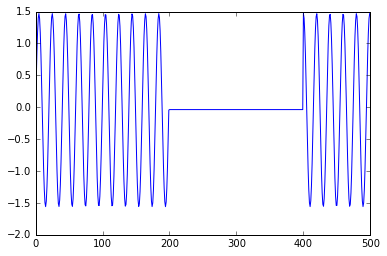

In [103]:
pb.build()["Q"].plot()

In [98]:
calibrations[0].get_optimization_results()

({'dc_offsets': array([-0.08106372, -0.03649549]),
  'if_amplitudes': array([ 1.37004922,  1.51397047]),
  'if_offsets': array([-0.07197077, -0.04467704]),
  'if_phase': array([-1.64940977])},
 {'dc': -90.569381713867188,
  'if': [-20.212928771972656, -93.98870086669922, -111.54064178466797]})